<img src="assets/hpe_pri_grn_pos_rgb.png" alt="HPE Logo" width="200">


# PCAI Use Case Demo - License Plate Number Detection
## Step 3. Implement License Plate Number Detection.
In the previous two steps, we got the models to implement the License Plate Number Detection. So In this step, we will implement the License Plate Number Detection logic and deploy the application in the PCAI.

### 0. Prerequisites
Followed [2.Deploy_Model.ipynb](./2.Deploy_Model.ipynb), ensure that you have successfully deploy the model with **MLIS**. prior to running this notebook. 

### 1. Implement License Plate Number Detection 
In order to make OCR model read license plate only, we will detect license plate. And To make license detection more robust, we will leverage vehicle detection as well. So High level overview of process is 

1. Read Input. ( Frame or Image )
2. Detect Vehicle
3. crop the detected vehicles
4. Detect License Plate from cropped vehicle images
5. Crop the detected license plates
6. Read License Plate Number from cropped license plate images. 

In [1]:
%update_token

Token successfully refreshed.


### 1. Initialize the models.

In [2]:
from ultralytics import YOLO
import easyocr
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
!kubectl get svc |grep -i externalname

license-detectors-predictor                 ExternalName   <none>           istio-ingressgateway.istio-system.svc.cluster.local   80/TCP                                               75s


In [4]:
vehicle_tracker = YOLO("http://license-detectors-predictor.geuntak-6d6b6531.svc.cluster.local/vehicle_detector",task='detect')
license_detector = YOLO("http://license-detectors-predictor.geuntak-6d6b6531.svc.cluster.local/license_detector",task='detect')
plate_reader = easyocr.Reader(['en'],gpu=False)

Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Download complete


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Download complete.


### 2. Read the Sample Video file.

In [5]:
video_path = "resources/Samples/sample.mp4"
vehicle_conf = 0.6
license_conf = 0.25

cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

In [6]:
frame_num += 1
ret, frame = cap.read()

### 3. Do tracking inference. 
- YOLO's tracking task will track the object and keep the id of them. it can be leveraged to correct the results.

In [7]:
vehicle_results = vehicle_tracker.track(frame, persist=True,conf=vehicle_conf,classes=[2,3,5,7])[0]


0: 384x640 9 cars, 2 trucks, 188.4ms
Speed: 6.1ms preprocess, 188.4ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


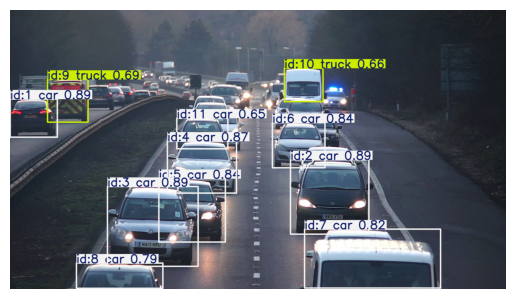

In [8]:
vehicle_rgb_img = cv.cvtColor(vehicle_results.plot(), cv.COLOR_BGR2RGB)

plt.imshow(vehicle_rgb_img)
plt.axis('off')
plt.show()

### 4. Crop the detected vehicles images

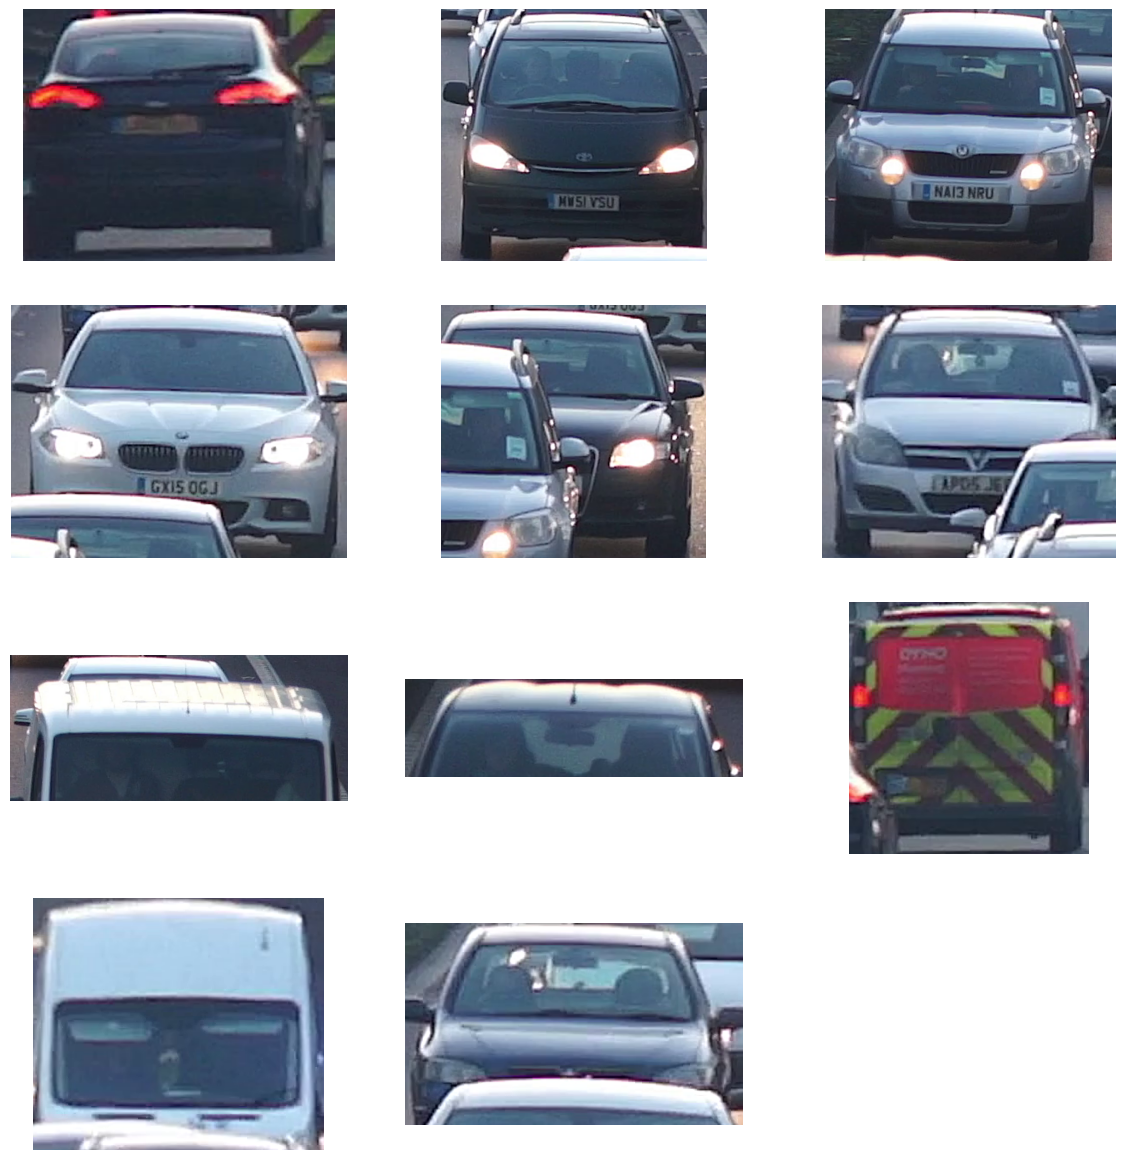

In [9]:
num_vehicles = len(vehicle_results.boxes.data.tolist())
cols = 3
rows = ( num_vehicles ) // cols + 1

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.tight_layout()
if rows == 1:
    axes = axes.reshape(1,-1)

for index,result in enumerate(vehicle_results.boxes.data.tolist()):
    x1, y1, x2, y2, track_id, score, class_id = result
    roi = frame[int(y1):int(y2), int(x1):int(x2)]
    vehicle_roi = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
    axes[int(index / cols), (index % cols)].imshow(vehicle_roi)
    axes[int(index / cols), (index % cols)].axis('off')

for i in range(num_vehicles, rows * cols):
    axes[int(i / cols), (i % cols)].axis('off')

plt.show()

### 5. Do Inference to detect License Plate from cropped vehicle images

In [10]:
license_detection_results = []

for index,result in enumerate(vehicle_results.boxes.data.tolist()):
    x1, y1, x2, y2, track_id, score, class_id = result
    roi = frame[int(y1):int(y2), int(x1):int(x2)]
    license_plates = license_detector(roi,conf=license_conf)[0]
    if len(license_plates.boxes.data.tolist()) > 0:
        license_detection_results.append({"roi": roi, "license_plates": license_plates})


0: 544x640 (no detections), 72.0ms
Speed: 3.3ms preprocess, 72.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 608x640 1 License_Plate, 77.3ms
Speed: 4.1ms preprocess, 77.3ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 576x640 1 License_Plate, 80.6ms
Speed: 3.6ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 (no detections), 68.3ms
Speed: 3.2ms preprocess, 68.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 (no detections), 75.5ms
Speed: 4.0ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 (no detections), 73.4ms
Speed: 3.3ms preprocess, 73.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

0: 288x640 (no detections), 42.0ms
Speed: 2.1ms preprocess, 42.0ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)

0: 192x640 (no detections), 30.5ms
Speed: 1.3ms preprocess, 30.5ms i

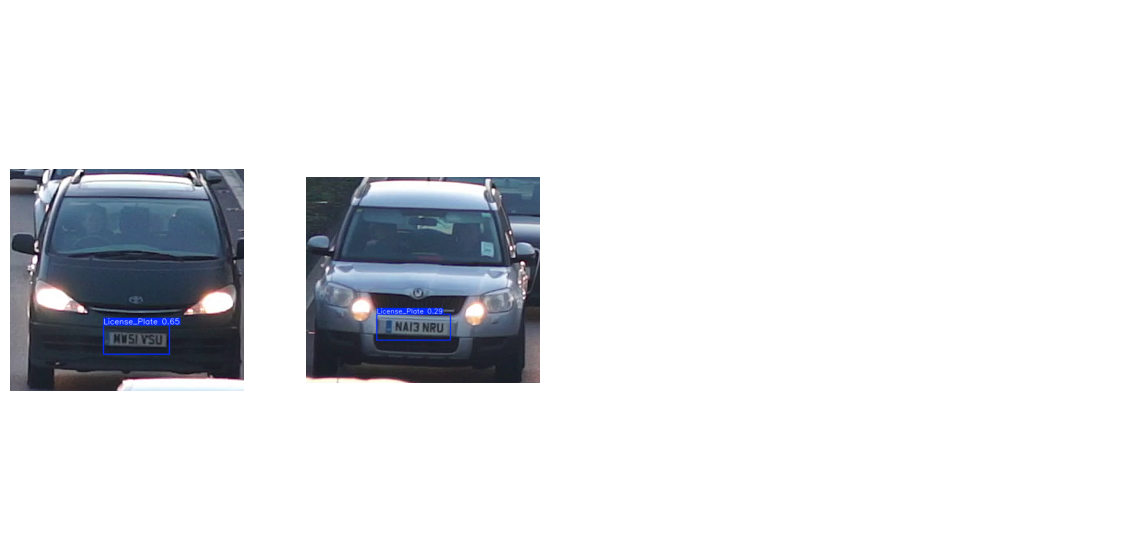

In [11]:
num_licenses = len(license_detection_results)
cols = 4
rows = ( num_licenses ) // cols + 1

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.tight_layout()
if rows == 1:
    axes = axes.reshape(1,-1)

for index,result in enumerate(license_detection_results):
    license_rgb_img = cv.cvtColor(result["license_plates"].plot(), cv.COLOR_BGR2RGB)
    
    axes[int(index / 4), (index % 4)].imshow(license_rgb_img)
    axes[int(index / 4), (index % 4)].axis('off')

for i in range(num_licenses, rows * cols):
    axes[int(i / 4), (i % 4)].axis('off')

plt.show()

### 6. Crop the License Plate image and convert RGB Image to Gray Scale image 
- Simplified channel will make OCR task more efficiently. Since it provides less data, higher contrast, complexity of OCR task is reduced  

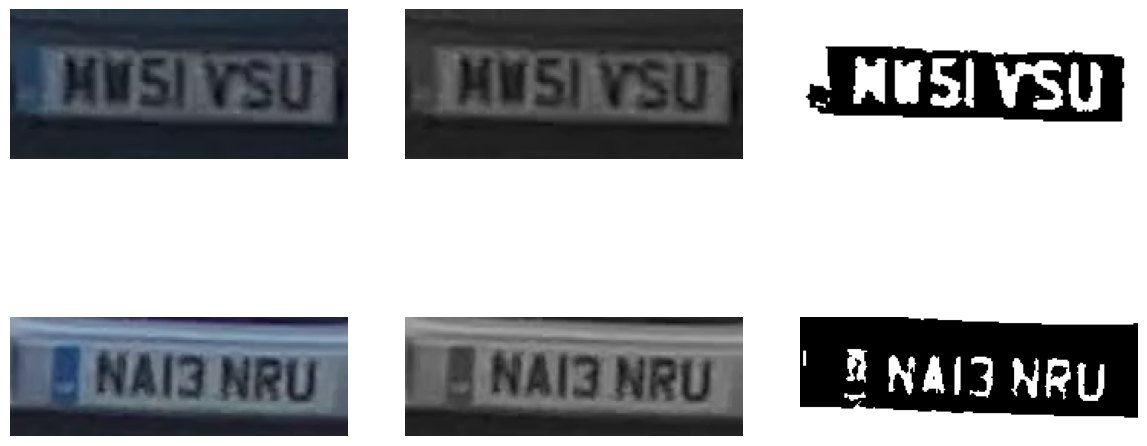

In [12]:
num_vehicle = len(license_detection_results)
cols = 3
rows = num_vehicle

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.tight_layout()
if rows == 1:
    axes = axes.reshape(1,-1)

cropped_license_images = []

for index,result in enumerate(license_detection_results):
    # x1, y1, x2, y2, track_id, score, class_id = result
    roi = result["roi"]
    license_plates = result["license_plates"]
    for license_plate in license_plates.boxes.data.tolist():
        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
        
        # crop license plate
        plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
        # de-colorize
        plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
        # posterize
        _, plate_threshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)
        axes[index, 0].imshow(cv.cvtColor(plate, cv.COLOR_BGR2RGB))
        axes[index, 1].imshow(cv.cvtColor(plate_gray, cv.COLOR_BGR2RGB))
        axes[index, 2].imshow(cv.cvtColor(plate_threshold, cv.COLOR_BGR2RGB))
        axes[index, 0].axis('off')
        axes[index, 1].axis('off')
        axes[index, 2].axis('off')
        cropped_license_images.append({'plate': plate,'plate_gray':plate_gray ,'plate_threshold':plate_threshold})
        
plt.show()

### 7. Read License Plate Number

In [13]:
for index,cropped_license_image in enumerate(cropped_license_images):
    plate = cropped_license_image['plate']
    plate_gray = cropped_license_image['plate_gray']
    plate_threshold = cropped_license_image['plate_threshold']
    
    rgb_detections = plate_reader.readtext(plate)
    gray_detections = plate_reader.readtext(plate_gray)
    binary_detections = plate_reader.readtext(plate_threshold)

    if len(rgb_detections) > 0 and len(binary_detections) > 0 and len(binary_detections) > 0:
        _,rgb_text, rgb_score = rgb_detections[0]
        _,gray_text, gray_score = gray_detections[0]
        _, bin_text, bin_score = binary_detections[0]
        print(f"# {index} plate result\nRGB channel Result : {rgb_text} / {rgb_score}\nGray channel result : {gray_text} / {gray_score}\nOne channel result : {bin_text} / {bin_score} \n")

# 0 plate result
RGB channel Result : MVSIYSU / 0.11847765819373367
Gray channel result : MVSIYSU / 0.1635400771374603
One channel result : NLSISU / 0.28724421212783297 

# 1 plate result
RGB channel Result : Nai3 NRU / 0.3359873375399907
Gray channel result : Nai? NRU / 0.3127046477114775
One channel result : 7 / 0.10723260258258538 



In [14]:
cap.release()

### 8. Deploy the License Plate Number Detection application
In this part, we will deploy license plate number detection application which implement above logic with MLIS endpoint.</br>

#### Import Framework
1. Get the Helm chart from <link>
2. Log in to your HPE PCAI environment (AIE)
3. Navigate to **“Tools & Frameworks”**
4. Select **"Import Framework"**
5. Fill in the framework details:
   - **Framework Name** : A short name for the framework
   - **Description** : Brief description
   - **Category** : Select appropriate category (e.g., "Data Science")
   - **Framework Icon** : Upload an icon for the application (sample icon included in the project)
   - **Helm Chart → Upload Helm Package File (tar.gz, tgz)** : Upload the packaged chart
   - **Namespace** : Target namespace for deployment
   - (Optional) Release Name: Custom release name
   - **Framework Values.yaml** : Review your values.yaml content and Configure MLIS Deployment. ( **Required** )</br></br>
   ```yaml
   backend:
     appConfig:
       detectors:       
         option : mlis
         mlis_deployment_name : "license-detectors"
         mlis_deployment_namespace : "geuntak-6d6b6531"
         server_token: <MLIS Token>
   ```
</br>
6. Click "Submit" to deploy


<img src="assets/4.import_framework_details.png" alt="4.import_framework_details.png" width="350"><img src="assets/4.import_framework_chart.png" alt="4.import_framework_chart.png" width="350"><img src="assets/4.import_framework_values.png" alt="4.import_framework_values.png" width="350"><img src="assets/4.import_framework_review.png" alt="4.import_framework_review.png" width="350"><img src="assets/4.import_framework_imported.png" alt="4.import_framework_imported.png" width="350">

#### values.yaml description

|Parameter|Description|Examples|
|:---|:---|:---|
|frontend.appConfig.logo_url|Configure the App Logo|assets/hpe_pri_grn_pos_rgb.png|
|backend.appConfig.detectors.option|Detector deployment type|mlis|
|backend.appConfig.detectors.mlis_deployment_name|MLIS Deployment Name|license-detectors|
|backend.appConfig.detectors.mlis_deployment_namespace|MLIS Deployment Namespace|geuntak-6d6b6531|
|backend.appConfig.detectors.server_token|MLIS Token for Detector deployment|MLIS Token |
|backend.appConfig.detectors.vehicle_detector|Triton Engine Name for Vehicle detection Model|vehicle_detector|
|backend.appConfig.detectors.license_detector|Triton Engine Name for license plate detection Model|license_detector|
|ezua.virtualService.endpoint|Virtual service hostname|lp-number-detection.${DOMAIN_NAME}|
|ezua.virtualService.istioGateway|Istio gateway reference|istio-system/ezaf-gateway|

### 9. Execute Application

#### Use Case 1 : Object Detection
1. Select Vehicle Detection Usecase
2. Select Data type ( Image or Video )
3. Configure Confidence Threshold
4. Upload Input File. ( If you select video type, Please configure Video Length Ratio for Inference. )
5. Select Model ( Vehicle Detector or License Plate Detector )
6. Check target Classes
7. Click Start


<img src="assets/5.app-object-detection.png" alt="5.app-object-detection.png" width="800">

#### Use Case 2 : License Plate Number Detection
1. Select License Number Detection Usecase
2. Select Data type ( Image or Video )
3. Configure Confidence Threshold for each model
4. Upload Input File. ( If you select video type, Please configure Video Length Ratio for Inference.
5. Click Start to request inference. it will return Raw format Inference Result as DataFrame format
6. Click Visualize to request Visualization. it will return Visualized Result by Image or Video.

<img src="assets/5.app-lp-number-detection.png" alt="5.app-lp-number-detection.png" width="800">

<video src="assets/sample_result_480.mov" type="video/mov" controls>